In [2]:
%cd / 
! git clone https://github.com/galoren287199/ex2.git
%cd ex2
%ls


/
Cloning into 'ex2'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 10), reused 13 (delta 1), pack-reused 0
Unpacking objects: 100% (31/31), done.
/ex2
data/  ex2.ipynb  lm.py  ptb-lm.py  reader.py  README.md


In [3]:

import collections
import os

import numpy as np
def read_words(filename):
  with open(filename, "r") as f:
    return f.read().replace("\n", "<eos>").split()


def build_vocab(filename):
  data = read_words(filename)
  words=set(data)
  word_to_id = dict(zip(words, range(len(words))))
  id_to_word = dict((v, k) for k, v in word_to_id.items())
  return word_to_id, id_to_word


def file_to_word_ids(filename, word_to_id):
  data = read_words(filename)
  return [word_to_id[word] for word in data if word in word_to_id]


def files_raw_data(paths,names,word_to_id,trainRatio=1):
    data={}
    for idx,path in enumerate(paths):
        data[names[idx]]=file_to_word_ids(path,word_to_id)
    if trainRatio!=1: 
        data['train']=RandomSampleAcordionRatio(data['train'],trainRatio)
    return data     
def RandomSampleAcordionRatio(data,ratio):
     start_idx=int(np.random.uniform(0,1-ratio)*len(data))
     end_idx=start_idx+int(ratio*len(data))
     return data[start_idx:end_idx]
def full_path_files(base,names_of_files):
    return [base+name for name in names_of_files]

def ptb_iterator(raw_data, batch_size, num_steps):
       
  """Iterate on the raw PTB data.
  This generates batch_size pointers into the raw PTB data, and allows
  minibatch iteration along these pointers. 
  
  make the raw data iterater in dim  [batch_size,seq_len] when all the data store at 
  [batch_size,batch_len]-> batch_len*batch*size=len(data)
  
  Args:
    raw_data: one of the raw data outputs from ptb_raw_data.
    batch_size: int, the batch size.
    num_steps: int, the number of unrolls.
  Yields:
    Pairs of the batched data, each a matrix of shape [batch_size, num_steps].
    The second element of the tuple is the same data time-shifted to the
    right by one.
  Raises:
    ValueError: if batch_size or num_steps are too high.
  """
  
  raw_data = np.array(raw_data, dtype=np.int32)
  data_len = len(raw_data)
  batch_len = data_len // batch_size
  data = np.zeros([batch_size, batch_len], dtype=np.int32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1)]


  epoch_size = (batch_len - 1) // num_steps

  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x, y)

In [4]:
import torch.nn as nn
from torch.autograd import Variable
import torch.tensor as tensor 
class Rnn(nn.Module):
  """Simple LSMT-based language model"""
  
  #to change embbeding dim 
  #to change drop out  val 
   # change init_hidden 
   # check the lerning rate
   #change  dp_keep_prob
   
   # consider of we need clip_grad_norm
   #consider using step insted 
   
   #CHECK FOR PREPLXTIY CALC 
   
  def __init__(self,net,embedding_dim, seq_len, batch_size, vocab_size, num_layers, dp_keep_prob,lr=1,lr_decay_base=2,ephocs_witout_decay=4):
    super(Rnn, self).__init__()
    self.embedding_dim = embedding_dim
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.dp_keep_prob = dp_keep_prob
    self.num_layers = num_layers
    self.dropout = nn.Dropout(1 - dp_keep_prob)
    self.net_name=net
    self.first_lr=lr
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    if net=="lstm":
        self.net = nn.LSTM(input_size=embedding_dim,
                                hidden_size=embedding_dim,
                                num_layers=num_layers,
                                dropout=1 - dp_keep_prob)
    
    else:
        self.net =nn.GRU(input_size=embedding_dim,
                                hidden_size=embedding_dim,
                                num_layers=num_layers,
                                dropout=1 - dp_keep_prob)
    self.sm_fc = nn.Linear(in_features=embedding_dim,
                           out_features=vocab_size)
    self.lr=lr
    self.ephocs_witout_decay=ephocs_witout_decay
    self.lr_decay_base=lr_decay_base
    self.init_weights()
    self.train_perplexity=[]
    self.test_perplexity=[]
    self.already_decayed=False
  def init_weights(self):
    init_range = 0.1
    nn.init.xavier_normal_(self.word_embeddings.weight.data)
    # self.word_embeddings.weight.data.uniform_(-init_range, init_range)
    self.sm_fc.bias.data.fill_(0.0)
    nn.init.xavier_normal_(self.sm_fc.weight.data)
    
    # self.sm_fc.weight.data.uniform_(-init_range, init_range)

  def init_hidden(self):
    weight = next(self.parameters()).data
    if self.net_name=="lstm":
        return (Variable(weight.new(self.num_layers, self.batch_size, self.embedding_dim).zero_()),
            Variable(weight.new(self.num_layers, self.batch_size, self.embedding_dim).zero_()))
    else :
        return   Variable(weight.new(self.num_layers, self.batch_size, self.embedding_dim).zero_())

  def forward(self, inputs, hidden):
    if self.dp_keep_prob==1:
      embeds=self.word_embeddings(inputs)
    else : 
      embeds = self.dropout(self.word_embeddings(inputs))
    net_out, hidden = self.net(embeds, hidden)
    if self.dp_keep_prob!=1:
       net_out = self.dropout(net_out)
    logits = self.sm_fc(net_out.view(-1, self.embedding_dim))
    return logits.view(self.seq_len, self.batch_size, self.vocab_size), hidden

def repackage_hidden(h):
  """Wraps hidden states in new Variables, to detach them from their history."""
  if type(h) is  not tuple:
    return Variable(h.data)
  # else:
  #  return tuple(repackage_hidden(v) for v in h)
  else:
      temp=[]
      for i in h:
          temp.append(Variable(i.data))
      return tuple(temp)


Welcome to ex2 ! 

follwing is menu to chose the desired settings for model:

press 1 to see dafault settings for all sections

press 2 to chose lstm without dropot

print 3 to chose lstm with dropout

print 4 to chose gru without dropout

print 5 to chose gru with dropot

print anything else for defualt seeting - lstm without droput 
Feel free to change the values in args dict  as you wish for custom settings
2

print 1 to  new model  or 2 for load from default save

1
{'seq_len': 30, 'batch_size': 20, 'inital_lr': 20, 'num_epochs': 15, 'lr_decay_base': 2, 'ephocs_witout_decay': 4, 'trainRatio': 1, 'data': 'data/', 'hidden_size': 200, 'num_layers': 2, 'dp_keep_prob': 1, 'net': 'lstm', 'load': '', 'save': 'lstm_model.pt', 'log_path': './log_lstm.txt'}
------- training ------

Train perplexity at epoch 0:   366.18
test perplexity at epoch 0:   213.77
save model new result :)

Train perplexity at epoch 1:   161.93
test perplexity at epoch 1:   160.41
save model new result :)

Train perpl

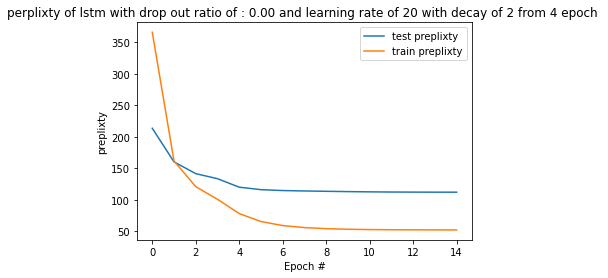

----Done! ---


In [12]:



import time
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn
import torch.tensor as tensor 
import numpy as np
import matplotlib.pyplot as plt
from os import path



args={}
args_lstm={"seq_len":30,"batch_size":20,"inital_lr":20,"num_epochs":15,  "lr_decay_base":2,"ephocs_witout_decay":4
         ,"trainRatio":1,"data":"data/", "hidden_size":200 ,"num_layers":2, "dp_keep_prob":1,  "net":"lstm", "load":"lstm_model.pt","save":"lstm_model.pt", "log_path":"./log_lstm.txt" }


# args_gru={"seq_len":20,"batch_size":20,"inital_lr":17,"num_epochs":18,  "lr_decay_base":1.9,"ephocs_witout_decay":4
#          ,"trainRatio":1,"data":"data/", "hidden_size":200 ,"num_layers":2, "dp_keep_prob":1,  "net":"gru", "load":"","save":"lm_model_lstm.pt", "log_path":"./log_lstm.txt" }
args_gru={"seq_len":30,"batch_size":20,"inital_lr":20,"num_epochs":15,  "lr_decay_base":2,"ephocs_witout_decay":4
    
         ,"trainRatio":1,"data":"data/", "hidden_size":200 ,"num_layers":2, "dp_keep_prob":1,  "net":"gru", "load":"gru_model.pt","save":"gru_model.pt", "log_path":"./log_gru.txt" }

def save_checkpoint(model,save_path, epoch,trained):
    torch.save({
        'model': model,
        'epoch': epoch,
        'trained':trained
    }, save_path)
def load_checkpoint(load_path):
    
    checkpoint = torch.load(load_path)
    model=checkpoint['model']
    epoch = checkpoint['epoch']
    trained=checkpoint['trained']
    if  not trained:
        print('continue to train from epoch {}, see log file for history :)\n'.format(epoch))
    else:
        print('load model from file! validate on valid data :)\n')
    return model,epoch ,trained

    
def run_epoch(model, data, is_train=False, lr=1.0):
  """Runs the model on the given data."""
  if is_train:
    model.train()
  else:
    model.eval()
    
  num_of_seq = ((len(data) // model.batch_size) - 1) // model.seq_len
  start_time = time.time()
  hidden = model.init_hidden()
  costs = 0.0
  iters = 0
  for step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.seq_len)):
    inputs = Variable(torch.from_numpy(x.astype(np.int64)).transpose(0, 1).contiguous()).to(device)
    model.zero_grad()
    hidden = repackage_hidden(hidden)
    outputs, hidden = model(inputs, hidden)
    targets = Variable(torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous()).to(device)
    tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))

    loss = criterion(outputs.view(-1, model.vocab_size), tt)
    costs += loss.item() * model.seq_len
    iters += model.seq_len

    if is_train:
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
      for p in model.parameters():
        p.data.add_(-lr, p.grad.data)
      # if step % (num_of_seq // 10) == 10:
      #   print("{} perplexity: {:8.2f} speed: {} wps".format(step * 1.0 / num_of_seq, np.exp(costs / iters),
      #                                                  iters * model.batch_size / (time.time() - start_time)))
  return np.exp(costs / iters)    


def train(model=None,epoch=None):
    #load model or create it     
    if model!=None:
        model,epoch_start=model,epoch
    else:      
        epoch_start=0
        model = Rnn(net=args["net"],embedding_dim=200,seq_len=args["seq_len"], batch_size=args["batch_size"],
                 vocab_size=vocab_size, num_layers=args["num_layers"], dp_keep_prob=args["dp_keep_prob"],lr=args["inital_lr"],lr_decay_base=args["lr_decay_base"],ephocs_witout_decay=args["ephocs_witout_decay"])
    epoch_num=args["num_epochs"]
     #convert to device 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # if load is avilable get lr and num of ephoc else take the defualt. 
    cur_epoch=0
    f = open(args["log_path"], "a")
    try:
        for epoch in range(epoch_start,epoch_num):
            cur_epoch=epoch
            if ( epoch>=model.ephocs_witout_decay and not  model.already_decayed ):
                  if (100*((abs(model.test_perplexity[-1]- model.test_perplexity[-2]))/model.test_perplexity[-1]) )<2 and model.dp_keep_prob!=1: # only if drop out is enabled then enable not to cut lr when the othe condition exist.
                    pass
                  else:
                    model.lr=model.lr/model.lr_decay_base
                    model.already_decayed=True# for serealization 
                    print("decay lr by {}".format(model.lr_decay_base))
            #run one epoch
            train_perplexity = run_epoch(model, data["train"], True, model.lr)
            test_perplexity=run_epoch(model, data["test"])
            # collect results 
            model.train_perplexity.append(train_perplexity)
            model.test_perplexity.append(test_perplexity)
            model.already_decayed=False
            #check for save model 
            print('Train perplexity at epoch {}: {:8.2f}'.format(epoch, train_perplexity))
            print('test perplexity at epoch {}: {:8.2f}'.format(epoch, test_perplexity))
            if min(model.test_perplexity)==test_perplexity:
                print("save model new result :)\n")
                save_checkpoint(model,args["save"],epoch,True)
            #write to logger 
            f.write('Train perplexity at epoch {}: {:8.2f}\n'.format(epoch, train_perplexity))
            f.write('test perplexity at epoch {}: {:8.2f}\n\n'.format(epoch, test_perplexity))
        # write best reult        
        preplixty_of_train=min(model.train_perplexity)
        preplixty_of_test=min(model.test_perplexity)
        f.write('train perplexity at best epoch {}'.format(preplixty_of_train))
        f.write('test perplexity at best epoch {}'.format(preplixty_of_test))
        f.write('test perplexity at last ephoc  {}: {:8.2f}'.format(epoch,test_perplexity))
        model.batch_size = 1 # to make sure we process all the data in the test later
        return model
    except: 
      #save model if problem is occured/ trigger stop by user->ctrl+c
        print("problem or stop by user ,saving current model state for continue later! ")
        save_checkpoint(model,args["save"],cur_epoch,False)
        return False 

def PlotResult(model):
            f1 = plt.figure()
            plt.plot(range(len(model.test_perplexity)),model.test_perplexity)
            plt.plot(range(len(model.train_perplexity)),model.train_perplexity)   
            plt.legend(["test preplixty", "train preplixty"], loc ="upper right")
            plt.xlabel("Epoch #")
            plt.ylabel("preplixty")
            plt.title("perplixty of {} with drop out ratio of : {:4.2f} and learning rate of {} with decay of {} from {} epoch ".format(model.net_name,1-model.dp_keep_prob,model.first_lr,model.lr_decay_base,model.ephocs_witout_decay))
            plt.show()
def UIuser(args):
  print("Welcome to ex2 ! \n\nfollwing is menu to chose the desired settings for model:\n")

  print("press 1 to see dafault settings for all sections\n")
  print("press 2 to chose lstm without dropot\n")
  print("print 3 to chose lstm with dropout\n")
  print("print 4 to chose gru without dropout\n")
  print("print 5 to chose gru with dropot\n")
  print("print anything else for defualt seeting - lstm without droput ")
  print("Feel free to change the values in args dict  as you wish for custom settings")
  m_input=input()
  if m_input=="1":
    print("lstm:\n\n{}\nlstm with drooout: drop_value:\n\n{}\ngru:\n\n{}\ngru with drooput: drop value\n\n{}\n".format(args_lstm,0.7,args_gru,0.7))
    print("chose what you wana do next fromm the option 2-5 above")
    m_input=input()

  print("\nprint 1 to  new model  or 2 for load from default save\n")
  input_2=input()  
  
  if m_input=="2":
    if input_2=="1":
      args_lstm['load']=""
      args=args_lstm
  elif m_input=="3":
    args_lstm_do= args_lstm.copy()
    args_lstm_do["dp_keep_prob"]=0.7
    args_lstm_do["ephocs_witout_decay"]=8
    args_lstm_do["num_epochs"]=20
    if input_2=="1":
      args_lstm_do['load']=""
    else:
      args_lstm_do["load"]="lstm_model_do.pt"
    args_lstm_do[ "save"]="lstm_model_do.pt"
    args_lstm_do["log_path"]:"./log_lstm_do.txt"
    args=args_lstm_do
  elif m_input=="4":
    if input_2=="1":
      args_gru['load']=""
    args=args_gru
  elif m_input=="5":
    args_gru_do=args_gru.copy()
    args_gru_do["dp_keep_prob"]=0.7
    args_gru_do["ephocs_witout_decay"]=4
    args_gru_do["num_epochs"]=20
    if input_2=="1":
      args_lstm_do['load']=""
    else:
      args_gru_do["load"]="gru_model_do.pt"
    args_gru_do[ "save"]="gru_model_do.pt"
    args_gru_do["log_path"]:"./log_gru_do.txt"
    args=args_gru_do
  else:
    args=args_lstm
  return args 

if __name__ == "__main__":
    args=UIuser(args)
    print(args)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #open log file results 
    if path.exists(args["load"]):
      mode='a'
    else:
      mode='w'
    f = open(args["log_path"],mode)
    f.write("hello from training\n")
    f.close()
    ## --read data and parse to voacb 
    paths=["ptb.train.txt","ptb.valid.txt","ptb.test.txt"]
    names_of_files=["train","valid","test"]
    paths = full_path_files(args["data"],paths)
    train_name=paths[0]
    word_to_id, id_2_word =build_vocab(train_name)
    # return for each file list of the words in the file encoded to id by the word to id dict 
    data=files_raw_data(paths,names_of_files,word_to_id,args["trainRatio"])
    vocab_size = len(word_to_id)
    criterion = nn.CrossEntropyLoss()  


    print ("------- training ------\n")
    if path.exists(args['load']):
        model,epoch,trained=load_checkpoint(args['load'])
        if not trained:
           model=train(model,epoch)
    else :
       model=train() 
        
    print ("---- end training ------\n")
    if model:
        model.batch_size = 1 # to make sure we process all the data
        print("---  Validating ---")
      
        print('Validation Perplexity: {:8.2f}'.format(run_epoch(model,  data["valid"])))
        PlotResult(model)
        print("----Done! ---")
   
    
   
    
# get hyper params with optuna     
    

# study = optuna.create_study( direction='minimize', pruner=optuna.pruners.MedianPruner(
#     n_startup_trials=5, n_warmup_steps=7, interval_steps=1)
# )
# study.optimize(train, n_trials=70)
# plot_optimization_history(study)

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))
